In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from graph_vis import draw_dot
import math

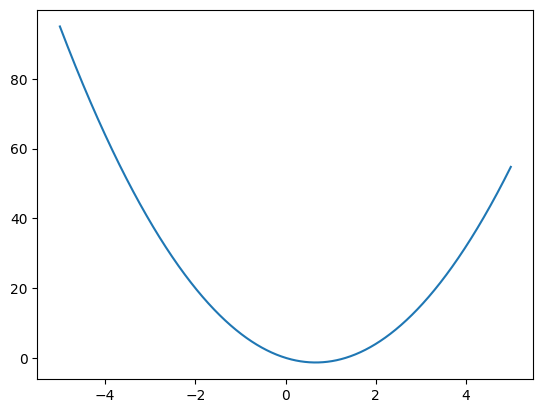

In [3]:
def f(x):
    return 3 * x**2 - 4 * x

xs = np.arange(-5, 5, 0.01)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [4]:
# Derivative
x = -10
h = 0.00000001
(f(x + h) - f(x))/h

-64.00000529538374

In [5]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c

b += h
d2 = a*b + c

print("d1: ", d)
print("d2: ", d2)
print("slope: ", (d2 - d)/h)

d1:  4.0
d2:  4.0002
slope:  2.0000000000042206


In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
        self._backward = lambda:None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        tanx = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(tanx, (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - tanx**2) * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other    
    
    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int / float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            x = self.data
            self.grad += other * (x**(other -1)) *out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op='exp')

        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [7]:
# Implement a simple NN manually

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1.__mul__(w1); x1w1.label='x1w1'
x2w2 = x2.__mul__(w2); x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'

e = (2 * n).exp(); e.label = 'e'

o =  (e - 1) / (e + 1); o.label = 'o'

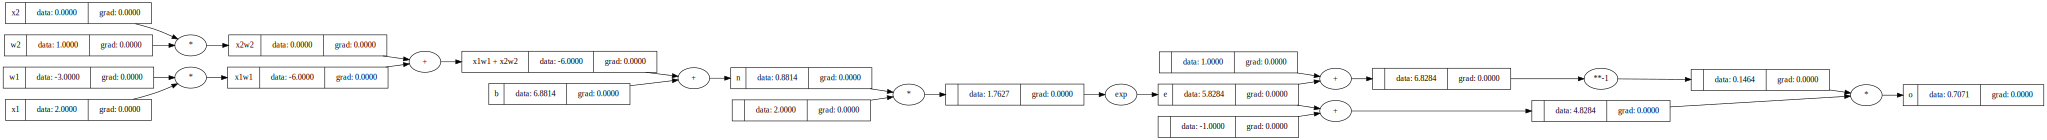

In [8]:
draw_dot(o)

In [9]:
# ====================
# | MANUAL BACKPROP  |
# ====================
# o.grad = 1.0
# n.grad = 1 - o.data**2 # diff(tanh(x)) = 1 - tanh(x) ** 2
# b.grad = 1.0 * n.grad # dn/db = 1; n = x1w1 + x2w2 + b

# x1w1x2w2.grad = 1.0 * n.grad # dn / d(x1w1+x2w1) = 1.0; see 'n'
# x1w1.grad = 1.0 * x1w1x2w2.grad # d(x1w1 + x2w2) / d(x1w1) = 1.0
# x2w2.grad = 1.0 * x1w1x2w2.grad
# # do/dx1 = do/dn * dn/d(x1w1+x2w2) * d(x1w1+x2w2)/d(x1w1) * d(x1w1)/dx1 ==> chain rule || d(x1w1)/dx1 ==> local
# x1.grad = w1.data * x1w1.grad # d(x1w1)/d(x1) = w1 ==> local; x1w1.grad ==> global
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad


In [10]:
#  CALLING BACKPROP FOR EVERY NODE|
# =================================

# o.grad = 1.0
# o._backward()
# n._backward()

# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

# x1._backward()
# x2._backward()
# w1._backward()
# w2._backward()

In [11]:
o.backward()

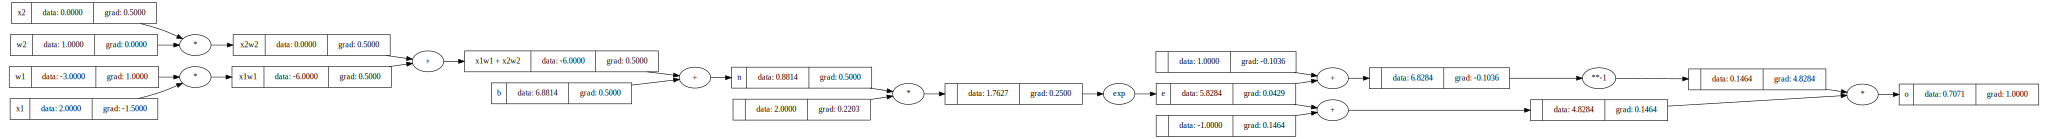

In [12]:
draw_dot(o)

In [13]:
# BUG: 
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = c * d; e.label = 'e'

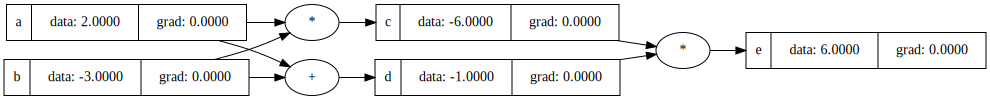

In [14]:
draw_dot(e)

In [15]:
e.backward()

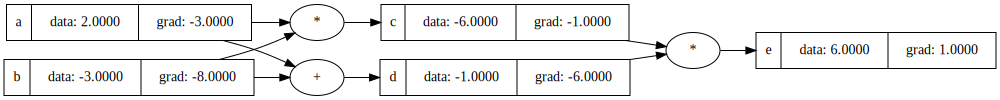

In [16]:
draw_dot(e)

In [17]:
a = Value(2.0, label='a')
f = a + a; f.label = 'f'
f.backward()

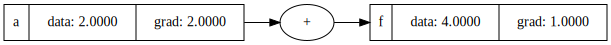

In [18]:
draw_dot(f)

In [19]:
2 + a


Value(data=4.0)

In [20]:
a - b

Value(data=5.0)

In [21]:
a - 1

Value(data=1.0)

In [22]:
1 - a

Value(data=-1.0)

In [23]:
a

Value(data=2.0)

In [24]:
a - 1

Value(data=1.0)

In [25]:
b

Value(data=-3.0)

In [26]:
a / b

Value(data=-0.6666666666666666)

In [27]:
a/2

Value(data=1.0)

In [28]:
3** -1

0.3333333333333333

In [29]:
# DOING THE SAME THING WITH PYTORCH
import torch

x1 = torch.tensor([2.0], requires_grad=True, dtype=torch.float64)
x2 = torch.tensor([0.0], requires_grad=True, dtype=torch.float64)

w1 = torch.tensor([-3.0], requires_grad=True, dtype=torch.float64)
w2 = torch.tensor([1.0], requires_grad=True, dtype=torch.float64)

b = torch.tensor([6.8813735870195432], requires_grad=True, dtype=torch.float64)

n = (x1 * w1) + (x2 *w2) + b
n.retain_grad()

o =  torch.tanh(n)
o.retain_grad()
o.backward()

print(f"x1: {x1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w1: {w1.grad.item()}")
print(f"w1: {w2.grad.item()}")
print(f"b: {b.grad.item()}")
print(f"o: {o.data.item()}")
print(f"o.grad: {o.grad.item()}")

x1: -1.4999999999999998
x2: 0.49999999999999994
w1: 0.9999999999999999
w1: 0.0
b: 0.49999999999999994
o: 0.7071067811865476
o.grad: 1.0


In [30]:
n.grad

tensor([0.5000], dtype=torch.float64)

In [31]:
x1

tensor([2.], dtype=torch.float64, requires_grad=True)

In [32]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # return w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):   
        return [params for neuron in self.neurons for params in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1])for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [params for layer in self.layers for params in layer.parameters()]
    

In [33]:
x = [1.0, 2.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.48941508466515293)

In [34]:
n.parameters()

[Value(data=0.1817160805407514),
 Value(data=-0.13017174976511892),
 Value(data=-0.15704155136256315),
 Value(data=0.6824832985754734),
 Value(data=-0.9553614849545988),
 Value(data=-0.656014870131955),
 Value(data=0.027695307475512188),
 Value(data=-0.10097640872403368),
 Value(data=-0.6683560759411309),
 Value(data=0.254754305932239),
 Value(data=0.5470591374739759),
 Value(data=-0.41548720208571943),
 Value(data=0.7158853674163481),
 Value(data=-0.608296936060875),
 Value(data=0.19403006546499602),
 Value(data=-0.16275134727148433),
 Value(data=0.5169813024222236),
 Value(data=-0.1262608913799057),
 Value(data=0.6041015723082859),
 Value(data=0.807306969147209),
 Value(data=-0.9867092910072968),
 Value(data=-0.3800169105167859),
 Value(data=0.3961848764108933),
 Value(data=0.11025494599677876),
 Value(data=-0.08380215140675973),
 Value(data=-0.7824719711875148),
 Value(data=-0.20974653467820303),
 Value(data=-0.7086519669457609),
 Value(data=0.4627845785580931),
 Value(data=-0.99143

In [51]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [54]:
for i in range(30):

    # Forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, y_pred)])
    print(i, ' ===> ', loss)

    # Backward pass
    for p in n.parameters(): # Zero the grads
        p.grad = 0 
    loss.backward()

    # Update
    for params in n.parameters():
        params.data += -0.01 * params.grad

0  ===>  Value(data=0.0035272878066094377)
1  ===>  Value(data=0.0035026661580165558)
2  ===>  Value(data=0.0034783949640706186)
3  ===>  Value(data=0.0034544667679491754)
4  ===>  Value(data=0.0034308743229609254)
5  ===>  Value(data=0.0034076105851996506)
6  ===>  Value(data=0.0033846687065039963)
7  ===>  Value(data=0.0033620420277083725)
8  ===>  Value(data=0.0033397240721708076)
9  ===>  Value(data=0.003317708539564933)
10  ===>  Value(data=0.003295989299923283)
11  ===>  Value(data=0.003274560387920578)
12  ===>  Value(data=0.003253415997385155)
13  ===>  Value(data=0.00323255047602849)
14  ===>  Value(data=0.00321195832038297)
15  ===>  Value(data=0.00319163417093737)
16  ===>  Value(data=0.003171572807462523)
17  ===>  Value(data=0.0031517691445173074)
18  ===>  Value(data=0.003132218227127608)
19  ===>  Value(data=0.003112915226630341)
20  ===>  Value(data=0.003093855436675283)
21  ===>  Value(data=0.0030750342693775714)
22  ===>  Value(data=0.003056447251614626)
23  ===>  Val

In [55]:
y_pred

[Value(data=0.9978137716994956),
 Value(data=-0.9464641360765368),
 Value(data=-0.9924152593851968),
 Value(data=0.9979642019609596)]

In [56]:
n.parameters()

[Value(data=0.7114548067210332),
 Value(data=0.3703936214328997),
 Value(data=-1.1444132776278622),
 Value(data=0.7586848013093045),
 Value(data=-0.9091689661315681),
 Value(data=-0.5161345315323651),
 Value(data=0.29345655057099124),
 Value(data=0.043050221964727284),
 Value(data=-0.9911443240282131),
 Value(data=-0.8356143389825785),
 Value(data=-1.6406831169282197),
 Value(data=-1.7172145424858545),
 Value(data=-0.28836424134462346),
 Value(data=0.6242651930320545),
 Value(data=9.033257410002653),
 Value(data=2.200666261697653),
 Value(data=0.795557131423118),
 Value(data=-0.9431681507162837),
 Value(data=1.0317554957824004),
 Value(data=1.2036716501149172),
 Value(data=0.08673639626159944),
 Value(data=-0.39294510964534485),
 Value(data=0.3798542587934822),
 Value(data=0.18485867974453382),
 Value(data=-0.03525772111301984),
 Value(data=-0.7490453019044213),
 Value(data=0.05298998226964434),
 Value(data=-0.6418465290630153),
 Value(data=-0.6240196517421118),
 Value(data=-1.72669535

In [57]:
len(n.parameters())

41